In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as python_random

import tensorflow as tf
import tensorflow_hub as hub

yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle) # if there's an "SavedModel file does not exist at:", delete that folder and rerun it

2023-02-23 23:55:15.703462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-23 23:55:19.579504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# scan data directories
import glob

nature_file_list = []
nature_file_list += glob.glob('../data/interim/AmbisonicSoundLibrary/nature/*')
nature_file_list += glob.glob('../data/interim/GoogleAudioSet/Outside, rural or natural/*')
nature_file_list += glob.glob('../data/interim/youtube/NomadicAmbience_nature/*')
nature_file_list += glob.glob('../data/interim/S2L_LULC/non_urban/*')
nature_file_list += glob.glob('../data/interim/S2L_LULC/urban_0_25/*')

city_file_list = []
city_file_list += glob.glob('../data/interim/GoogleAudioSet/Outside, urban or manmade/*')
city_file_list += glob.glob('../data/interim/youtube/NomadicAmbience_city/*')
# city_file_list += glob.glob('../data/interim/S2L_LULC/urban_26_100/*')

# these two directories have way too many files, which will biase the training toward the difference between these 2 them rather the category
NS_file_list = glob.glob('../data/interim/youtube/NatureSoundscapes/*')
SONYC_file_list = glob.glob('../data/interim/SONYC/**/*.pkl')

import random
random.seed(23)
n_files_minus = 1800
NS_file_list_sampled = random.sample(NS_file_list, 300)
nature_file_list += NS_file_list_sampled


SONYC_file_list_sampled = random.sample(SONYC_file_list, len(nature_file_list)-len(city_file_list)) # compensate the difference
city_file_list += SONYC_file_list_sampled 

nature_source_list = ['nature_'+i.rsplit('/', 3)[1]+'/'+i.rsplit('/', 3)[2] for i in nature_file_list]
city_source_list = ['city_'+i.rsplit('/', -1)[3] for i in city_file_list]

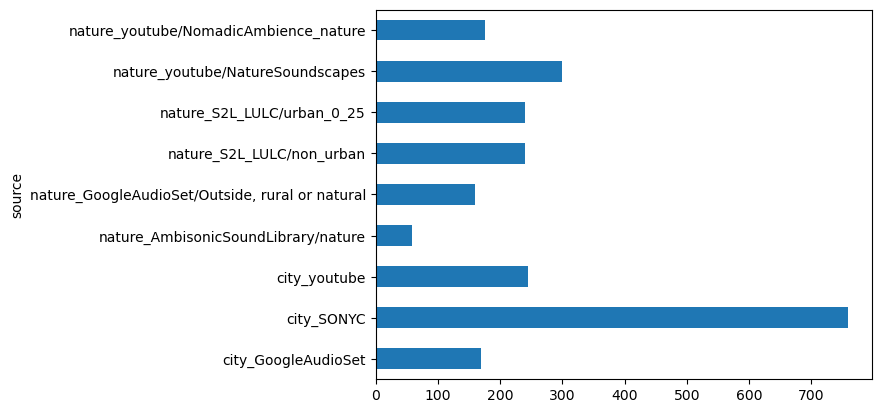

In [3]:
nature_df = pd.DataFrame({'file': nature_file_list, 'source': nature_source_list, 'category': 0})
city_df = pd.DataFrame({'file': city_file_list, 'source': city_source_list, 'category': 1})
df_all = pd.concat([nature_df, city_df], ignore_index=True)
source_count = df_all.groupby(['source'])['file'].count()
ax = source_count.plot.barh()
plt.show()

In [4]:
# make the weights as the inverse of the number of files per source
df_all['weight'] = df_all['source'].apply(lambda s: 1/source_count.loc[s])

In [5]:
# extract the youtube ID of the file out and put it as 'file_group'
df_all['file_group'] = df_all['file'].apply(lambda st: st[st.find('/youtube/')+1:st.rfind("_")])

# for the rows that were not extracted from youtube, replace the 'file_group' by 'file', as they are all from different sources
df_all.loc[~df_all['file_group'].str.contains('youtube'), 'file_group'] = df_all.loc[~df_all['file_group'].str.contains('youtube'), 'file']
df_all

,file,source,category,weight,file_group
0,../data/interim/AmbisonicSoundLibrary/nature/W...,nature_AmbisonicSoundLibrary/nature,0,0.017241,../data/interim/AmbisonicSoundLibrary/nature/W...
1,../data/interim/AmbisonicSoundLibrary/nature/R...,nature_AmbisonicSoundLibrary/nature,0,0.017241,../data/interim/AmbisonicSoundLibrary/nature/R...
2,../data/interim/AmbisonicSoundLibrary/nature/A...,nature_AmbisonicSoundLibrary/nature,0,0.017241,../data/interim/AmbisonicSoundLibrary/nature/A...
3,../data/interim/AmbisonicSoundLibrary/nature/W...,nature_AmbisonicSoundLibrary/nature,0,0.017241,../data/interim/AmbisonicSoundLibrary/nature/W...
4,../data/interim/AmbisonicSoundLibrary/nature/L...,nature_AmbisonicSoundLibrary/nature,0,0.017241,../data/interim/AmbisonicSoundLibrary/nature/L...
...,...,...,...,...,...
2341,../data/interim/SONYC/audio-17/35_017644.pkl,city_SONYC,1,0.001318,../data/interim/SONYC/audio-17/35_017644.pkl
2342,../data/interim/SONYC/audio-0/27_006416.pkl,city_SONYC,1,0.001318,../data/interim/SONYC/audio-0/27_006416.pkl
2343,../data/interim/SONYC/audio-2/27_008560.pkl,city_SONYC,1,0.001318,../data/interim/SONYC/audio-2/27_008560.pkl
2344,../data/interim/SONYC/audio-5/05_019072.pkl,city_SONYC,1,0.001318,../data/interim/SONYC/audio-5/05_019072.pkl


In [6]:
from sklearn.model_selection import StratifiedGroupKFold

# Split the data into folds using StratifiedKFold
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=23)
for fold, (train_idx, val_idx) in enumerate(sgkf.split(X=df_all, y=df_all['source'], groups=df_all['file_group'])):
    # Assign the fold number to each row in the DataFrame
    df_all.loc[val_idx, 'fold'] = fold
    
df_all['fold'] = df_all['fold'].astype('int')

# need to shuffle the rows before deep learning
df_all = df_all.sample(frac=1, random_state=23).reset_index(drop=True) 
df_all

,file,source,category,weight,file_group,fold
0,../data/interim/S2L_LULC/non_urban/s2llg003_19...,nature_S2L_LULC/non_urban,0,0.004167,../data/interim/S2L_LULC/non_urban/s2llg003_19...,9
1,../data/interim/youtube/NomadicAmbience_city/Y...,city_youtube,1,0.004098,youtube/NomadicAmbience_city/YF3pj_3mdMc,8
2,../data/interim/AmbisonicSoundLibrary/nature/A...,nature_AmbisonicSoundLibrary/nature,0,0.017241,../data/interim/AmbisonicSoundLibrary/nature/A...,0
3,../data/interim/SONYC/audio-1/48_027156.pkl,city_SONYC,1,0.001318,../data/interim/SONYC/audio-1/48_027156.pkl,9
4,../data/interim/S2L_LULC/non_urban/s2lam013_18...,nature_S2L_LULC/non_urban,0,0.004167,../data/interim/S2L_LULC/non_urban/s2lam013_18...,4
...,...,...,...,...,...,...
2341,../data/interim/youtube/NomadicAmbience_city/D...,city_youtube,1,0.004098,youtube/NomadicAmbience_city/DK1pACuFpUw,7
2342,../data/interim/SONYC/audio-4/19_008194.pkl,city_SONYC,1,0.001318,../data/interim/SONYC/audio-4/19_008194.pkl,4
2343,../data/interim/youtube/NatureSoundscapes/CmkS...,nature_youtube/NatureSoundscapes,0,0.003333,youtube/NatureSoundscapes/CmkS6Bfmcfs,3
2344,../data/interim/S2L_LULC/urban_0_25/s2lam051_2...,nature_S2L_LULC/urban_0_25,0,0.004167,../data/interim/S2L_LULC/urban_0_25/s2lam051_2...,4


In [7]:
# df_all.to_csv('../train_val_test_split_Feb21.csv')
# df_all.to_csv('../train_val_test_sgkf_Feb22.csv')
df_all.to_csv('../train_val_test_sgkf_Feb23.csv')

# Convert data into TF format

In [8]:
filenames = df_all['file']
targets = df_all['category']
folds = df_all['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [9]:
def load_wav_pkl(filename, wav_label='y'):
    import pickle
    # open a file, where you stored the pickled data
    file = open(filename, 'rb')

    # dump information to that file
    output = pickle.load(file)
    wav = output[wav_label]

    # close the file
    file.close()
    return wav

wav_list = []
for index, row in df_all.iterrows():
    if len(load_wav_pkl(row['file'])) == 160000:
        wav_list.append(load_wav_pkl(row['file']))
    else: # if the waveform is shorter (for unknown reason)
        temp_wav = load_wav_pkl(row['file'])
        print('short length: '+str(len(temp_wav)))
        wav_list.append(np.pad(temp_wav, (0,160000-len(temp_wav)),'mean')) # zero-padding at the end to 160000

wav_bg_list = []
for index, row in df_all.iterrows():
    if len(load_wav_pkl(row['file'], 'bg_y')) == 160000:
        wav_bg_list.append(load_wav_pkl(row['file'], 'bg_y'))
    else: # if the waveform is shorter (for unknown reason)
        temp_wav = load_wav_pkl(row['file'], 'bg_y')
#         print('short length: '+str(len(temp_wav)))
        wav_bg_list.append(np.pad(temp_wav, (0,160000-len(temp_wav)),'mean')) # zero-padding at the end to 160000

wav_fg_list = []
for index, row in df_all.iterrows():
    if len(load_wav_pkl(row['file'], 'fg_y')) == 160000:
        wav_fg_list.append(load_wav_pkl(row['file'], 'fg_y'))
    else: # if the waveform is shorter (for unknown reason)
        temp_wav = load_wav_pkl(row['file'], 'fg_y')
#         print('short length: '+str(len(temp_wav)))
        wav_fg_list.append(np.pad(temp_wav, (0,160000-len(temp_wav)),'mean')) # zero-padding at the end to 160000

short length: 159992
short length: 151683
short length: 159993
short length: 146099
short length: 151461
short length: 153357
short length: 159880
short length: 148006
short length: 153242
short length: 159999
short length: 159997
short length: 159880
short length: 157848
short length: 156480
short length: 159880
short length: 159880


In [10]:
# main_ds = tf.data.Dataset.from_tensor_slices((np.stack(wav_list, axis = 0), df_all['category'], df_all['fold']))
# main_ds_fg = tf.data.Dataset.from_tensor_slices((np.stack(wav_fg_list, axis = 0), df_all['category'], df_all['fold']))
# main_ds_bg = tf.data.Dataset.from_tensor_slices((np.stack(wav_bg_list, axis = 0), df_all['category'], df_all['fold']))

# main_ds.element_spec

In [11]:
# # applies the embedding extraction model to a wav data
# def extract_embedding(wav_data, label, fold):
#     # run YAMNet to extract embedding from the wav data
#     scores, embeddings, spectrogram = yamnet_model(wav_data)
#     num_embeddings = tf.shape(embeddings)[0]
#     return (embeddings,
#             tf.repeat(label, num_embeddings),
#             tf.repeat(fold, num_embeddings))

# # extract embedding
# main_ds = main_ds.map(extract_embedding).unbatch()
# main_ds_fg = main_ds_fg.map(extract_embedding).unbatch()
# main_ds_bg = main_ds_bg.map(extract_embedding).unbatch()

# main_ds.element_spec

In [12]:
main_ds = tf.data.Dataset.from_tensor_slices((np.stack(wav_list, axis = 0), df_all['category'], df_all['fold'], df_all['weight']))
main_ds_fg = tf.data.Dataset.from_tensor_slices((np.stack(wav_fg_list, axis = 0), df_all['category'], df_all['fold'], df_all['weight']))
main_ds_bg = tf.data.Dataset.from_tensor_slices((np.stack(wav_bg_list, axis = 0), df_all['category'], df_all['fold'], df_all['weight']))


# applies the embedding extraction model to a wav data
def extract_embedding_weight(wav_data, label, fold, weight):
    # run YAMNet to extract embedding from the wav data
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings),
            tf.repeat(weight, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding_weight).unbatch()
main_ds_fg = main_ds_fg.map(extract_embedding_weight).unbatch()
main_ds_bg = main_ds_bg.map(extract_embedding_weight).unbatch()

In [13]:
def split_ds(main_ds):
    cached_ds = main_ds.cache()
    train_ds = cached_ds.filter(lambda embedding, label, fold, weight: fold < 8)
    val_ds = cached_ds.filter(lambda embedding, label, fold, weight: fold == 8)
    test_ds = cached_ds.filter(lambda embedding, label, fold, weight: fold == 9)

    # remove the folds column now that it's not needed anymore
    remove_fold_column = lambda embedding, label, fold, weight: (embedding, label, weight)

    train_ds = train_ds.map(remove_fold_column)
    val_ds = val_ds.map(remove_fold_column)
    test_ds = test_ds.map(remove_fold_column)

    train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = split_ds(main_ds)
train_ds_bg, val_ds_bg, test_ds_bg = split_ds(main_ds_bg)
train_ds_fg, val_ds_fg, test_ds_fg = split_ds(main_ds_fg)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [15]:
# ## all 3 signals

# main_ds_all3 = tf.data.Dataset.from_tensor_slices((np.stack(wav_list, axis = 0), np.stack(wav_bg_list, axis = 0), np.stack(wav_fg_list, axis = 0), df_all['category'], df_all['fold']))


# # applies the embedding extraction model to a wav data
# def extract_embedding_3(wav_data_raw, wav_data_bg, wav_data_fg, label, fold):
#     # run YAMNet to extract embedding from the wav data
#     scores, embeddings_raw, spectrogram = yamnet_model(wav_data_raw)
#     scores, embeddings_bg, spectrogram = yamnet_model(wav_data_bg)
#     scores, embeddings_fg, spectrogram = yamnet_model(wav_data_fg)
#     num_embeddings_raw = tf.shape(embeddings_raw)[0]
#     return (tf.concat([embeddings_raw, embeddings_bg, embeddings_fg],1),
#             tf.repeat(label, num_embeddings_raw),
#             tf.repeat(fold, num_embeddings_raw))

# # extract embedding
# main_ds_3 = main_ds_all3.map(extract_embedding_3).unbatch()


# cached_ds_3 = main_ds_3.cache()
# train_ds_3 = cached_ds_3.filter(lambda embedding, label, fold: fold < 8)
# val_ds_3 = cached_ds_3.filter(lambda embedding, label, fold: fold == 8)
# test_ds_3 = cached_ds_3.filter(lambda embedding, label, fold: fold == 9)

# # remove the folds column now that it's not needed anymore
# remove_fold_column = lambda embedding, label, fold: (embedding, label)

# train_ds_3 = train_ds_3.map(remove_fold_column)
# val_ds_3 = val_ds_3.map(remove_fold_column)
# test_ds_3 = test_ds_3.map(remove_fold_column)

# train_ds_3 = train_ds_3.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
# val_ds_3 = val_ds_3.cache().batch(32).prefetch(tf.data.AUTOTUNE)
# test_ds_3 = test_ds_3.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [16]:
# ## raw signal
# cached_ds = main_ds.cache()
# train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 8)
# val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 8)
# test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 9)

# # remove the folds column now that it's not needed anymore
# remove_fold_column = lambda embedding, label, fold: (embedding, label)

# train_ds = train_ds.map(remove_fold_column)
# val_ds = val_ds.map(remove_fold_column)
# test_ds = test_ds.map(remove_fold_column)

# train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
# val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
# test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
# ## background sound
# cached_ds_bg = main_ds_bg.cache()
# train_ds_bg = cached_ds_bg.filter(lambda embedding, label, fold: fold < 8)
# val_ds_bg = cached_ds_bg.filter(lambda embedding, label, fold: fold == 8)
# test_ds_bg = cached_ds_bg.filter(lambda embedding, label, fold: fold == 9)

# # remove the folds column now that it's not needed anymore
# remove_fold_column = lambda embedding, label, fold: (embedding, label)

# train_ds_bg = train_ds_bg.map(remove_fold_column)
# val_ds_bg = val_ds_bg.map(remove_fold_column)
# test_ds_bg = test_ds_bg.map(remove_fold_column)

# train_ds_bg = train_ds_bg.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
# val_ds_bg = val_ds_bg.cache().batch(32).prefetch(tf.data.AUTOTUNE)
# test_ds_bg = test_ds_bg.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [18]:
# ## foreground sound
# cached_ds_fg = main_ds_fg.cache()
# train_ds_fg = cached_ds_fg.filter(lambda embedding, label, fold: fold < 8)
# val_ds_fg = cached_ds_fg.filter(lambda embedding, label, fold: fold == 8)
# test_ds_fg = cached_ds_fg.filter(lambda embedding, label, fold: fold == 9)

# # remove the folds column now that it's not needed anymore
# remove_fold_column = lambda embedding, label, fold: (embedding, label)

# train_ds_fg = train_ds_fg.map(remove_fold_column)
# val_ds_fg = val_ds_fg.map(remove_fold_column)
# test_ds_fg = test_ds_fg.map(remove_fold_column)

# train_ds_fg = train_ds_fg.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
# val_ds_fg = val_ds_fg.cache().batch(32).prefetch(tf.data.AUTOTUNE)
# test_ds_fg = test_ds_fg.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [19]:
# ## all 3 signals
# cached_ds_3 = main_ds_3.cache()
# train_ds_3 = cached_ds_3.filter(lambda embedding, label, fold: fold < 8)
# val_ds_3 = cached_ds_3.filter(lambda embedding, label, fold: fold == 8)
# test_ds_3 = cached_ds_3.filter(lambda embedding, label, fold: fold == 9)

# # remove the folds column now that it's not needed anymore
# remove_fold_column = lambda embedding, label, fold: (embedding, label)

# train_ds_3 = train_ds_3.map(remove_fold_column)
# val_ds_3 = val_ds_3.map(remove_fold_column)
# test_ds_3 = test_ds_3.map(remove_fold_column)

# train_ds_3 = train_ds_3.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
# val_ds_3 = val_ds_3.cache().batch(32).prefetch(tf.data.AUTOTUNE)
# test_ds_3 = test_ds_3.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [20]:
# # training weight vactor
# training_weights = df_all[df_all['fold']<8]['weight'].to_numpy

# Model of raw signal

In [29]:
my_classes = ['city', 'nature']
tf.keras.backend.clear_session()
tf.random.set_seed(23)
np.random.seed(23)
python_random.seed(23)


raw_model = tf.keras.Sequential([
#     tf.keras.layers.Dropout(.5, input_shape=(1024,), name='input_embedding'),
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='raw_model')

raw_model.summary()

Model: "raw_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [30]:
adam = tf.keras.optimizers.Adam(learning_rate=0.001)

raw_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=adam,
#                     optimizer="adam",
                  weighted_metrics=[],
                    metrics=['accuracy'])

# callback will be used in the other models below too
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [23]:
history = raw_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
1182/1182 [==============================] - 180s 148ms/step - loss: 0.0015 - accuracy: 0.8104 - val_loss: 0.0015 - val_accuracy: 0.8230
Epoch 2/20
1182/1182 [==============================] - 6s 5ms/step - loss: 0.0014 - accuracy: 0.8295 - val_loss: 0.0014 - val_accuracy: 0.8376
Epoch 3/20
1182/1182 [==============================] - 6s 5ms/step - loss: 0.0014 - accuracy: 0.8374 - val_loss: 0.0015 - val_accuracy: 0.8100
Epoch 4/20
1182/1182 [==============================] - 6s 5ms/step - loss: 0.0013 - accuracy: 0.8435 - val_loss: 0.0015 - val_accuracy: 0.8257
Epoch 5/20
1182/1182 [==============================] - 7s 6ms/step - loss: 0.0013 - accuracy: 0.8481 - val_loss: 0.0015 - val_accuracy: 0.8396
Epoch 6/20
1182/1182 [==============================] - 7s 6ms/step - loss: 0.0013 - accuracy: 0.8476 - val_loss: 0.0016 - val_accuracy: 0.8491
Epoch 7/20
1182/1182 [==============================] - 7s 6ms/step - loss: 0.0013 - accuracy: 0.8518 - val_loss: 0.0015 - val_accur

In [24]:
# this is the accuracy per YAMNet sample, not the accuracy per audio file
loss, accuracy = raw_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

144/144 [==============================] - 2s 7ms/step - loss: 0.0013 - accuracy: 0.8642
Loss:  0.0013097489718347788
Accuracy:  0.8641921281814575


In [25]:
def acc_by_audio(model, test_ds, y_true):
    n_sample_per_audio = 20
    y_pred = model.predict(test_ds)
    y_reshaped = y_pred.reshape(-1, n_sample_per_audio, 2) # reshape to audio*sample*binary_prediction
    y_pred_by_row = y_reshaped.mean(axis=1).argmax(axis=1)
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_true, y_pred_by_row), y_pred_by_row


In [26]:
test_df = df_all[df_all['fold']==9]
acc, y_pred = acc_by_audio(raw_model, test_ds, y_true = test_df['category'])
print(acc)

144/144 [==============================] - 0s 2ms/step
0.925764192139738


In [27]:
from sklearn.metrics import accuracy_score
test_df['pred'] = y_pred
acc_source = test_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_14144/2037315006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = y_pred


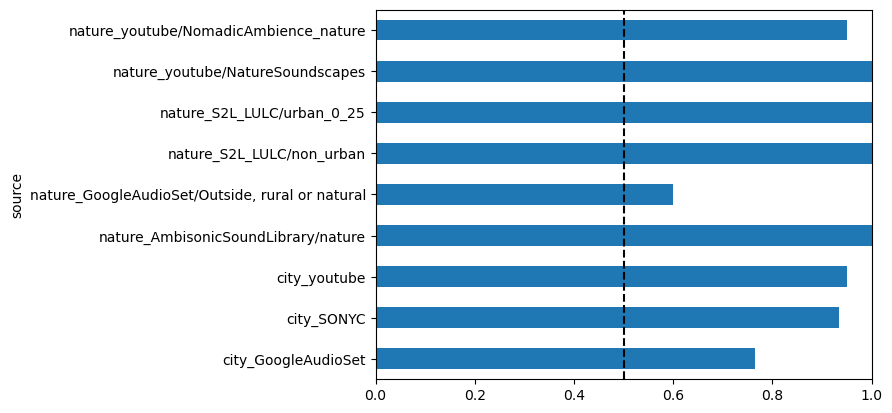

In [28]:
ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

********* below has not been revised (Feb 24)

# Model of background signal

In [25]:
my_classes = ['city', 'nature']
tf.keras.backend.clear_session()
tf.random.set_seed(23)
np.random.seed(23)
python_random.seed(23)


bg_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='bg_model')

bg_model.summary()

Model: "bg_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 131,458
Trainable params: 131,458
Non-trainable params: 0
_________________________________________________________________


In [26]:
bg_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer="adam",
                    metrics=['accuracy'])

history = bg_model.fit(train_ds_bg,
                       epochs=20,
                       validation_data=val_ds_bg,
                       callbacks=callback)

Epoch 1/20
1247/1247 [==============================] - 172s 134ms/step - loss: 0.2736 - accuracy: 0.8884 - val_loss: 0.2740 - val_accuracy: 0.8830
Epoch 2/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.2296 - accuracy: 0.9057 - val_loss: 0.2999 - val_accuracy: 0.8719
Epoch 3/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.2091 - accuracy: 0.9152 - val_loss: 0.3025 - val_accuracy: 0.8772
Epoch 4/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.1887 - accuracy: 0.9234 - val_loss: 0.3167 - val_accuracy: 0.8791
Epoch 5/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.1739 - accuracy: 0.9311 - val_loss: 0.3085 - val_accuracy: 0.8906
Epoch 6/20
1247/1247 [==============================] - 2s 2ms/step - loss: 0.1577 - accuracy: 0.9373 - val_loss: 0.3286 - val_accuracy: 0.8800
Epoch 7/20
1247/1247 [==============================] - 4s 3ms/step - loss: 0.1488 - accuracy: 0.9421 - val_loss: 0.3638 - val_accur

In [27]:
loss, accuracy = bg_model.evaluate(test_ds_bg)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

159/159 [==============================] - 2s 6ms/step - loss: 0.8430 - accuracy: 0.8387
Loss:  0.8430272340774536
Accuracy:  0.8387351632118225


In [28]:
test_df = df_all[df_all['fold']==9]
acc, y_pred = acc_by_audio(bg_model, test_ds_bg, y_true = test_df['category'])
print(acc)

159/159 [==============================] - 0s 973us/step
0.8656126482213439


In [29]:
from sklearn.metrics import accuracy_score
test_df['pred'] = y_pred
acc_source = test_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_88584/2037315006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = y_pred


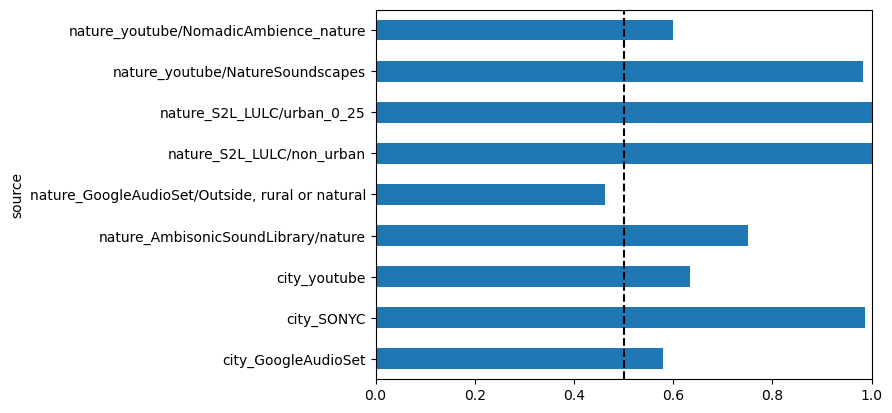

In [30]:
ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

# Model of foreground signal

In [31]:
my_classes = ['city', 'nature']
tf.keras.backend.clear_session()
tf.random.set_seed(23)
np.random.seed(23)
python_random.seed(23)


fg_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='fg_model')

fg_model.summary()

Model: "fg_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 131,458
Trainable params: 131,458
Non-trainable params: 0
_________________________________________________________________


In [32]:
fg_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer="adam",
                    metrics=['accuracy'])

history = fg_model.fit(train_ds_fg,
                       epochs=20,
                       validation_data=val_ds_fg,
                       callbacks=callback)

Epoch 1/20
1247/1247 [==============================] - 185s 145ms/step - loss: 0.5358 - accuracy: 0.7336 - val_loss: 0.5192 - val_accuracy: 0.7306
Epoch 2/20
1247/1247 [==============================] - 3s 2ms/step - loss: 0.4968 - accuracy: 0.7564 - val_loss: 0.5133 - val_accuracy: 0.7336
Epoch 3/20
1247/1247 [==============================] - 3s 3ms/step - loss: 0.4825 - accuracy: 0.7651 - val_loss: 0.5120 - val_accuracy: 0.7398
Epoch 4/20
1247/1247 [==============================] - 3s 3ms/step - loss: 0.4679 - accuracy: 0.7763 - val_loss: 0.5036 - val_accuracy: 0.7487
Epoch 5/20
1247/1247 [==============================] - 3s 3ms/step - loss: 0.4565 - accuracy: 0.7808 - val_loss: 0.4954 - val_accuracy: 0.7551
Epoch 6/20
1247/1247 [==============================] - 3s 2ms/step - loss: 0.4457 - accuracy: 0.7879 - val_loss: 0.4954 - val_accuracy: 0.7445
Epoch 7/20
1247/1247 [==============================] - 3s 3ms/step - loss: 0.4353 - accuracy: 0.7940 - val_loss: 0.4918 - val_accur

In [33]:
loss, accuracy = fg_model.evaluate(test_ds_fg)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

159/159 [==============================] - 3s 8ms/step - loss: 0.7408 - accuracy: 0.6982
Loss:  0.7407734394073486
Accuracy:  0.6982213258743286


In [34]:
test_df = df_all[df_all['fold']==9]
acc, y_pred = acc_by_audio(fg_model, test_ds_fg, y_true = test_df['category'])
print(acc)

159/159 [==============================] - 0s 1ms/step
0.7905138339920948


In [35]:
from sklearn.metrics import accuracy_score
test_df['pred'] = y_pred
acc_source = test_df.groupby(['source']).apply(lambda x: accuracy_score(x['category'], x['pred']))

/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_88584/2037315006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred'] = y_pred


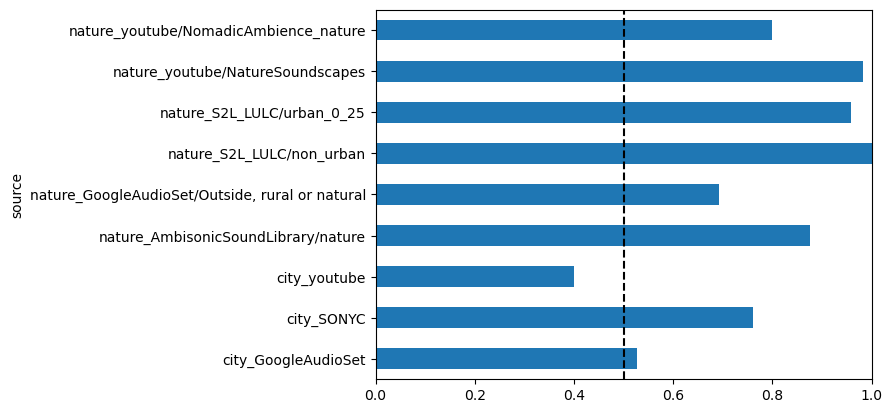

In [36]:
ax = acc_source.plot.barh()
ax.axvline(x=0.5, color='k', linestyle='--')
ax.set_xlim(0,1)
plt.show()

# Model of 3 signals

In [37]:
# my_classes = ['city', 'nature']
# tf.keras.backend.clear_session()
# tf.random.seta_seed(23)

# all3_model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(3072), dtype=tf.float32,
#                           name='input_embedding'),
#     tf.keras.layers.Dense(1024, activation='relu'),
# #     tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(len(my_classes))
# ], name='all3_model')

# all3_model.summary()

In [38]:
# all3_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                     optimizer="adam",
#                     metrics=['accuracy'])

# # callback will be used in the other models below too
# callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
#                                             patience=3,
#                                             restore_best_weights=True)


# history = all3_model.fit(train_ds_3,
#                        epochs=20,
#                        validation_data=val_ds_3,
#                        callbacks=callback)

In [39]:
# loss, accuracy = all3_model.evaluate(test_ds_3)

# print("Loss: ", loss)
# print("Accuracy: ", accuracy)

In [40]:
# test_df = df_all[df_all['fold']==9]
# acc = acc_by_audio(all3_model, test_ds_3, y_true = test_df['category'])
# print(acc)